# Khiva's features extraction application 
This interactive application shows some of the capabilities provided by the Khiva library for times-series’ feature extraction and machine learning. 
This use case consists on the analysis of 100 time-series provided by commercial sites during 2012 which are tagged by subindustry.  
This exercise is focused on: 
1. Extract the time series features. 
2. Predict the subindustry of some sites. 

## Module importing 
We are using Khiva’s array, features and library modules. 

In [32]:
from khiva.features import *
from khiva.library import *
from khiva.array import *
import khiva

import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=Warning)


import sklearn.utils
from sklearn.preprocessing import scale
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import time

In [16]:
%matplotlib inline
%pylab
pylab.rcParams['figure.figsize'] = (18, 6)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Metadata load 
This is anonymised 5-minute energy usage data for 100 commercial/ industrial sites for 2012. 
The sites metadata contains the site ID, the industry, square footage, lat/lng and timezone. 

In [17]:
all_sites = pd.read_csv("../../energy/data/data-enerNoc/all-data/meta/all_sites.csv")

## Loads the site id for each site 
This is needed to check the accuracy of the predictive modelling step. 

In [18]:
file_names = []

for name in all_sites["SITE_ID"].values:
    file_names.append(name)

## Backend
Prints the backend used. CPU, CUDA and OPENCL backends are available for Khiva.  
  
> This interactive application is being execute in **hub.mybinder** which doesn't provide a GPU and its CPU is quite limited so the features extraction is going to take some time. This application executed in a macOS High Sierra with a 2,9 GHz Intel Core i7 processor takes 8,34 seconds in extracting the features. 

In [24]:
print(khiva.library.get_backend())

KHIVABackend.KHIVA_BACKEND_CPU


## Data load
The original dataset contains 100 time-series, which was a total of 10,531,288 data points. This original dataset was re-dimensioned using Khiva and the result is a dataset of 100 time-series which is a total of 1,666,600 data points. After the re-dimension, the dataset was stored in a binary and then loaded into a Khiva Array. 

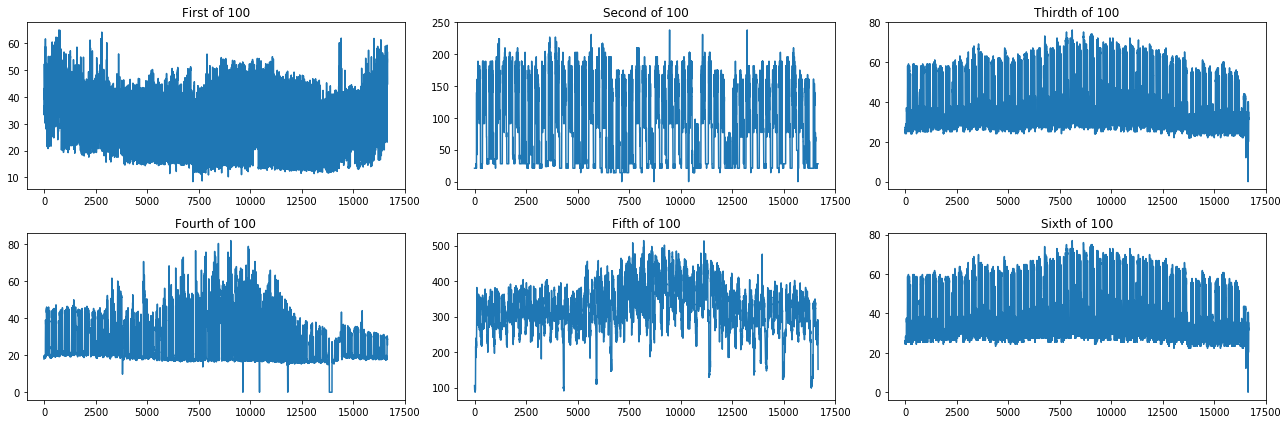

In [26]:
arr_tmp  = Array(np.load("../../energy/electric-consumption-rate-python/time-series-redimension-applied.npy"))
time_series= arr_tmp.to_numpy()
f, axarr = plt.subplots(2, 3)

axarr[0, 0].plot(range(len(time_series[0])), time_series[0])
axarr[0, 0].set_title('First of 100')
axarr[0, 1].plot(range(len(time_series[1])), time_series[1])
axarr[0, 1].set_title('Second of 100')
axarr[0, 2].plot(range(len(time_series[4])), time_series[4])
axarr[0, 2].set_title('Thirdth of 100')
axarr[1, 0].plot(range(len(time_series[2])), time_series[2])
axarr[1, 0].set_title('Fourth of 100')
axarr[1, 1].plot(range(len(time_series[3])), time_series[3])
axarr[1, 1].set_title('Fifth of 100')
axarr[1, 2].plot(range(len(time_series[5])), time_series[5])
axarr[1, 2].set_title('Sixth of 100')
plt.tight_layout()
plt.show()

## Features extraction 
we use Khiva to extract 28 features from the time-series, so we can generate a features matrix for applying a predictive modelling. As explained before, this interactive application is being executed in **hub.mybinder**, without GPUs and with a limited CPU, so it is going to take a while as the time series are compound by a big amount of data points. 

In [27]:
start = time.time()

features = np.stack([khiva.features.abs_energy(arr_tmp).to_numpy(),
                    khiva.features.absolute_sum_of_changes(arr_tmp).to_numpy(),
                    khiva.features.count_above_mean(arr_tmp).to_numpy(),
                    khiva.features.count_below_mean(arr_tmp).to_numpy(),
                    khiva.features.first_location_of_maximum(arr_tmp).to_numpy(),
                    khiva.features.first_location_of_minimum(arr_tmp).to_numpy(),
                    khiva.features.has_duplicates(arr_tmp).to_numpy(),
                    khiva.features.has_duplicate_max(arr_tmp).to_numpy(),
                    khiva.features.kurtosis(arr_tmp).to_numpy(),
                    khiva.features.last_location_of_maximum(arr_tmp).to_numpy(),
                    khiva.features.last_location_of_minimum(arr_tmp).to_numpy(),
                    khiva.features.has_duplicate_min(arr_tmp).to_numpy(),
                    khiva.features.longest_strike_above_mean(arr_tmp).to_numpy(),
                    khiva.features.longest_strike_below_mean(arr_tmp).to_numpy(),
                    khiva.features.maximum(arr_tmp).to_numpy(),
                    khiva.features.mean_absolute_change(arr_tmp).to_numpy(),
                    khiva.features.minimum(arr_tmp).to_numpy(),
                    khiva.features.number_crossing_m(arr_tmp, 0).to_numpy(),
                    khiva.features.mean(arr_tmp).to_numpy(),
                    khiva.features.median(arr_tmp).to_numpy(),
                    khiva.features.mean_change(arr_tmp).to_numpy(),
                    khiva.features.ratio_value_number_to_time_series_length(arr_tmp).to_numpy(),
                    khiva.features.skewness(arr_tmp).to_numpy(),
                    khiva.features.standard_deviation(arr_tmp).to_numpy(),
                    khiva.features.sum_of_reoccurring_values(arr_tmp).to_numpy(),
                    khiva.features.sum_values(arr_tmp).to_numpy(),
                    khiva.features.variance(arr_tmp).to_numpy(),
                    khiva.features.variance_larger_than_standard_deviation(arr_tmp).to_numpy()])

print("Time to extract the features : " + str(time.time() - start) + " seconds.")

features = features.transpose()


Time to extract the features : 27.80078434944153 seconds.


## Showing the features
Just a way to show the calculated features is to build a pandas dataframe and just display the five first entries.  For a comprehensive list of all features available in Khiva, have a look to the [features](http://khiva-python.readthedocs.io/en/latest/khiva.html#module-khiva.features) chapter in the documentation.

In [28]:
pandasDF = pd.DataFrame(columns=[
    'abs_energy','absolute_sum_changes','count_above_mean','count_below_mean',
    'first_location_of_maximum','first_location_of_minimum','has_duplicates',
    'has_duplicate_max','kurtosis','last_location_of_maximum','last_location_of_minimum',
    'has_duplicate_min','longest_strike_above_mean','longest_strike_below_mean',
    'maximum','mean_absolute_change','minimum','number_crossing_m',
    'mean','median','mean_change','ratio_value_number_to_time_series_length',
    'skewness','standard_deviation','sum_of_reoccurring_values','sum_values',
    'variance','variance_larger_than_standard_deviation'], data = features[0:,0:])
pandasDF.head(5)

,abs_energy,absolute_sum_changes,count_above_mean,count_below_mean,first_location_of_maximum,first_location_of_minimum,has_duplicates,has_duplicate_max,kurtosis,last_location_of_maximum,...,mean,median,mean_change,ratio_value_number_to_time_series_length,skewness,standard_deviation,sum_of_reoccurring_values,sum_values,variance,variance_larger_than_standard_deviation
0,1.841657e+07,34936.496094,8456.0,8210.0,0.043322,0.433397,1.0,0.0,-1.188631,0.043382,...,31.172253,31.540199,0.000272,0.099004,0.075534,11.546915,48996.738281,5.195161e+05,133.331238,1.0
1,2.239207e+08,103513.960938,8452.0,8214.0,0.567803,0.428477,1.0,1.0,-1.655309,0.793832,...,96.295357,97.774902,0.000419,0.036361,0.019660,64.530235,4148.448242,1.604865e+06,4164.151367,1.0
2,1.595003e+07,26026.353516,6616.0,10050.0,0.543622,0.578783,1.0,0.0,-0.005488,0.543682,...,28.198608,21.824400,0.000468,0.010620,0.876228,12.722180,6417.544434,4.699553e+05,161.853867,1.0
3,1.807100e+09,178849.937500,8696.0,7970.0,0.492380,0.001620,1.0,0.0,1.067946,0.492440,...,322.859924,325.911377,0.002751,0.786211,-0.542081,64.755188,950455.500000,5.380743e+06,4193.234375,1.0
4,2.928316e+07,25950.384766,6694.0,9972.0,0.486679,0.998380,1.0,0.0,-0.962161,0.486739,...,39.526604,34.006699,0.000300,0.003840,0.666650,13.953731,2706.530762,6.586651e+05,194.706604,1.0


## Features matrix and target definition.
Here, the features matrix and target matrix are defined in the following way: 
1. **Features matrix** Composed by the 28 features extracted. 
2. **Target matrix** Composed by the subindustries’ tag of each time series. 

In [29]:
y = all_sites["SUB_INDUSTRY"].values
X = features

## Features matrix pre-process 
A simple pre-process is executed to scale the features matrix. 

In [30]:
X = scale(X)

## Shuffle 
Several shuffles are done to distribute the samples

In [33]:
for i in range(15):
    X, y, file_names = sklearn.utils.shuffle(X, y, file_names, random_state=0)

## Predictive modelling 
In this step, we create a model, fit it and predict a subset of samples. 

The reason to choose SVC as classifier are the following: 
* More than 50 samples for the training and less than 100k in total. 
* The intention to predict a category.  
* All data is labelled. 

We can conclude that the results shown are quite decent after using this classificator. 

The parameters chosen are based on a grid search based on a cross-validation(CV) step, focused on the accuracy of the model and using a K-FOLD(K=10) CV method. 


In [34]:
files_test = []
list_test_indices = []
test_files = [92, 45, 761, 10, 766, 400, 673, 49, 144, 496, 731, 281, 213, 197, 399]

for i in range(len(file_names)):
    # choosing always the same examples for testing to ensure the same results ....
    if file_names[i] in test_files:
        list_test_indices.append(i)
        files_test.append(file_names[i])

X_train = np.delete(X, list_test_indices, 0)
X_test = np.take(X, list_test_indices, 0)
y_train = np.delete(y, list_test_indices)
y_test = np.take(y, list_test_indices)


# Search for the best model optimising by accuracy
clf = svm.SVC()
k_range_parameter = {'degree':[3,4],'shrinking':[True,False],'probability':[True,False]}
mygridsearch = GridSearchCV(clf, k_range_parameter, cv = 10, scoring = 'accuracy' )
mygridsearch.fit(X_train, y_train)

# Get the best one...
bestclassifier = mygridsearch.best_estimator_

# Run some predictions over the test subset
y_pred = bestclassifier.predict(X_test)

# Get some stats out...
print("NUMBER OF ERRORS: " + str(sum(y_pred != y_test)))
print("ERROR RATE: " + str(1 - sum(y_pred == y_test) / float(len(y_pred))) + "%")
print("ACCURACY: " + str(sum(y_pred == y_test) / float(len(y_pred))) + "%")
print("PARAMETERS USED: "+ str(mygridsearch.best_params_))

NUMBER OF ERRORS: 3
ERROR RATE: 0.19999999999999996%
ACCURACY: 0.8%
PARAMETERS USED: {'degree': 3, 'probability': True, 'shrinking': True}


interactive(children=(IntSlider(value=7, description='ts_index', max=14), Output()), _dom_classes=('widget-int…

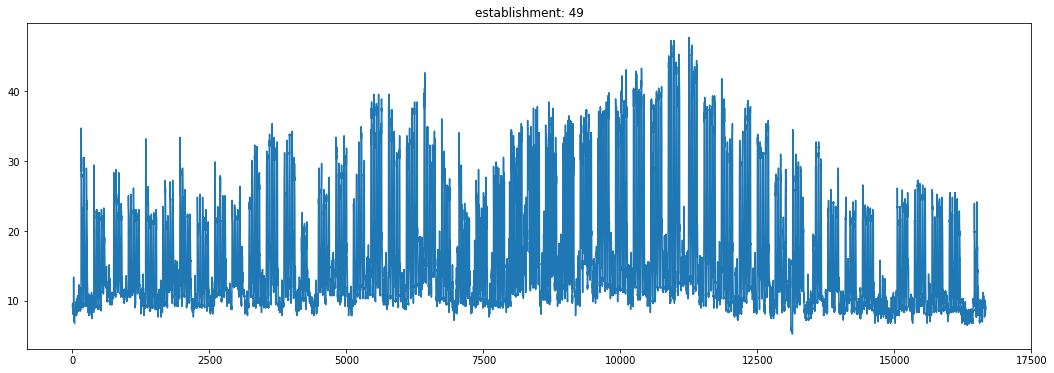

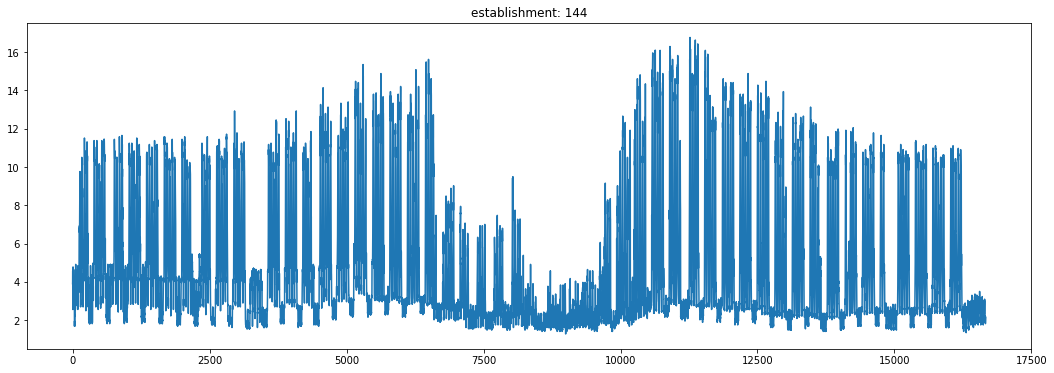

In [37]:

@interact(ts_index=(0, len(y_test)-1))
def run_prediction(ts_index):
    global y_test
    global y_pred
    global time_series
    global test_files
    
    print("Expected : " + y_test[ts_index])
    print("Predicted: " + y_pred[ts_index])
    
    plt.plot(range(len(time_series[list_test_indices[ts_index]])), time_series[list_test_indices[ts_index]])
    plt.title("establishment: " + str(test_files[ts_index]))
    plt.show()

    
    